In [1]:
using JuLIP

In [2]:
at = bulk(:Cu, cubic=true) * 16

JuLIP.Atoms{Float64,Int64}
  X: Array{StaticArrays.SArray{Tuple{3},Float64,1,3}}((16384,))
  P: Array{StaticArrays.SArray{Tuple{3},Float64,1,3}}((16384,))
  M: Array{Float64}((16384,)) [63.546, 63.546, 63.546, 63.546, 63.546, 63.546, 63.546, 63.546, 63.546, 63.546  …  63.546, 63.546, 63.546, 63.546, 63.546, 63.546, 63.546, 63.546, 63.546, 63.546]
  Z: Array{Int64}((16384,)) [29, 29, 29, 29, 29, 29, 29, 29, 29, 29  …  29, 29, 29, 29, 29, 29, 29, 29, 29, 29]
  cell: StaticArrays.SArray{Tuple{3,3},Float64,2,9}
  pbc: StaticArrays.SArray{Tuple{3},Bool,1,3}
  calc: JuLIP.NullCalculator JuLIP.NullCalculator()
  cons: JuLIP.NullConstraint JuLIP.NullConstraint()
  data: Dict{Any,JuLIP.JData}


In [3]:
length(at)÷2

8192

In [5]:
at.cell

3×3 StaticArrays.SArray{Tuple{3,3},Float64,2,9}:
 57.76   0.0    0.0 
  0.0   57.76   0.0 
  0.0    0.0   57.76

In [7]:
at.X[8191]

3-element StaticArrays.SArray{Tuple{3},Float64,1,3}:
 55.955
 54.15 
 27.075

* Coding the projection-QCE to test the algorithm

In [1]:
# include the function
using JuLIP, HDF5, JLD, PyPlot, Optim, LineSearches
include("./Juliacodes/myplot.jl")
include("./Juliacodes/geom.jl")
include("./Juliacodes/solver.jl")
include("./Juliacodes/IDX.jl")

map_sign_to_idx! (generic function with 1 method)

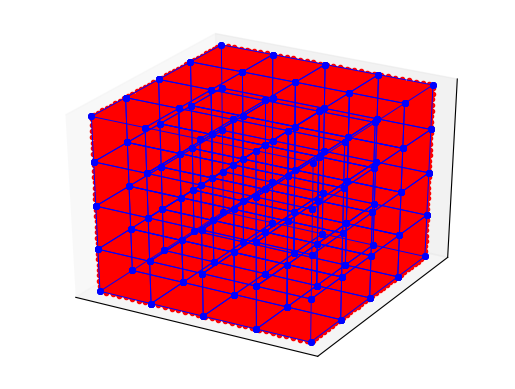

In [2]:
# 1. compute the atomistic solution and the initial mesh
L = 32
at = bulk(:Al, cubic=true) * L
r0 = rnn(:Al)
oc = 0.5*maximum(mat(at.X))*ones(3)
_, imid = findmin(sum(abs2, mat(at.X).-oc, 1))
at = bulk(:Al, cubic=true) * L
deleteat!(at, imid)
calc = LennardJones(σ = r0) * C2Shift(1.5*r0)
set_calculator!(at, calc)
set_constraint!(at, FixedCell(at))
figure(0)
myplotA(mat(at.X))
xa = copy(mat(at.X))
if !isfile(string("3DPoint", L, ".jld"))
    xold = copy(mat(at.X))
    tic()
    minimise!(at, verbose = 2, precond = :id)
    println("  Reference time: ")
    toc()
    xnew = copy(mat(at.X))
    u = xnew .- xold
    save(string("3DPoint", L, ".jld"), "u", u)
end
initial_grid = "grid-0.msh"
initial_cons = "constraints-0.txt"
geom = readmsh(at, initial_grid, initial_cons, L, 0)
initial = zeros(2, size(geom.X, 2) - length(geom.hanging_index))
Idx = get_initial_idx(geom.h[1], geom.oT)
idx = myindmin(xa, geom.X)
myplotgeom(geom);

In [4]:
function get_index_n(Idx, iA_in_T)
    i = Idx[iA_in_T[1]]
    for j = 2:length(iA_in_T)
        i = vcat(i, Idx[iA_in_T[j]]...)
    end
    return i
end

get_index_n (generic function with 1 method)

In [11]:
println("The number of the atomistic region: ", length(xa))

The number of the atomistic region: 393213


In [2]:
L = 32
println("The atomistic configuration is a ", L, "*", L, "*", L, " cell.")

The atomistic configuration is a 32*32*32 cell.
